# Hybrid ZFNet–QNN Pneumonia

Do id minim voluptate occaecat labore sint quis nostrud laboris eu in reprehenderit enim. Consequat non qui proident esse qui. Duis aliquip labore tempor ad dolor tempor in occaecat cupidatat consectetur sint tempor. Cillum elit pariatur sunt sunt.

## 1. Setup
### 1.1. Installing dependencies

In [8]:
!pip install pennylane scikit-learn numpy scipy matplotlib pandas pennylane-qiskit kagglehub scikit-image seaborn pillow opencv-python torch torchvision

  Using cached torch-2.9.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
Using cached torch-2.9.0-cp311-cp311-win_amd64.whl (109.3 MB)
Using cached torchvision-0.24.0-cp311-cp311-win_amd64.whl (4.0 MB)
Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl (15 kB)

   -------- ------------------------------- 1/5 [fsspec]
   ---------------- ----------------------- 2/5 [jinja2]
   ------------------------ --------------- 3/5 [torch]
   ------------------------ --------------- 3/5 [torch]
   ------------------------ --------------- 3/5 [torch]
   ------------------------ --------------- 3/5 [torch]
   ------

### 1.2. Importing all libraries and enviroment varieables

In [2]:
import os, json, time, pathlib, sys
import numpy as np
import pandas as pd
import random
from collections import Counter
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageStat, ImageFilter

import cv2
from skimage import measure, filters, morphology
import warnings

import kagglehub
import pennylane as qml


warnings.filterwarnings('ignore')

ROOT = "."
os.makedirs("results", exist_ok=True)
os.makedirs("media", exist_ok=True)
os.makedirs("data/features", exist_ok=True)

#Reproducibility
QSEED = int(os.environ.get("QSEED", 42))
np.random.seed(QSEED)

#Config mirrors repo env vars
LAYERS = int(os.environ.get("LAYERS", 2))
QUBITS = 4
ITERS = int(os.environ.get("ITERS", 40))
NSAMPLES = int(os.environ.get("NSAMPLES", 400))
LR = float(os.environ.get("LR", 0.03))
PATIENCE = int(os.environ.get("PATIENCE", 15))

#Eval-only shots (None = analytic)
EVAL_SHOTS = int(os.environ.get("EVAL_SHOTS", 256))

print({"LAYERS": LAYERS, "QUBITS": QUBITS, "ITERS": ITERS, "NSAMPLES": NSAMPLES, "LR": LR, "PATIENCE": PATIENCE, "EVAL_SHOTS": EVAL_SHOTS})

{'LAYERS': 2, 'QUBITS': 4, 'ITERS': 40, 'NSAMPLES': 400, 'LR': 0.03, 'PATIENCE': 15, 'EVAL_SHOTS': 256}


### 1.3. Data hadeling
#### 1.3.1 Downloding dataset

In [3]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:02<00:00, 39.4MB/s]

Extracting files...


Path to dataset files: C:\Users\quantum\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


#### 1.3.2. Analysising dataset

🔬 COMPREHENSIVE QUANTUM-READY CHEST X-RAY ANALYSIS

🚀 QUANTUM COMPUTING READINESS ANALYSIS
--------------------------------------------------
📐 Resolution Analysis:
  Most common resolution: 912×648
  Resolution diversity: 214 different sizes
  Standardization needed: Yes

🎯 Quantum Encoding Metrics:
  Average contrast: 0.497
  Average entropy: 7.316
  Average edge density: 0.0097
  Encoding complexity: High

⚡ Quantum Circuit Recommendations:
  Recommended qubits for amplitude encoding: 7
  Suggested preprocessing: Contrast normalization
  Feature extraction focus: Intensity patterns


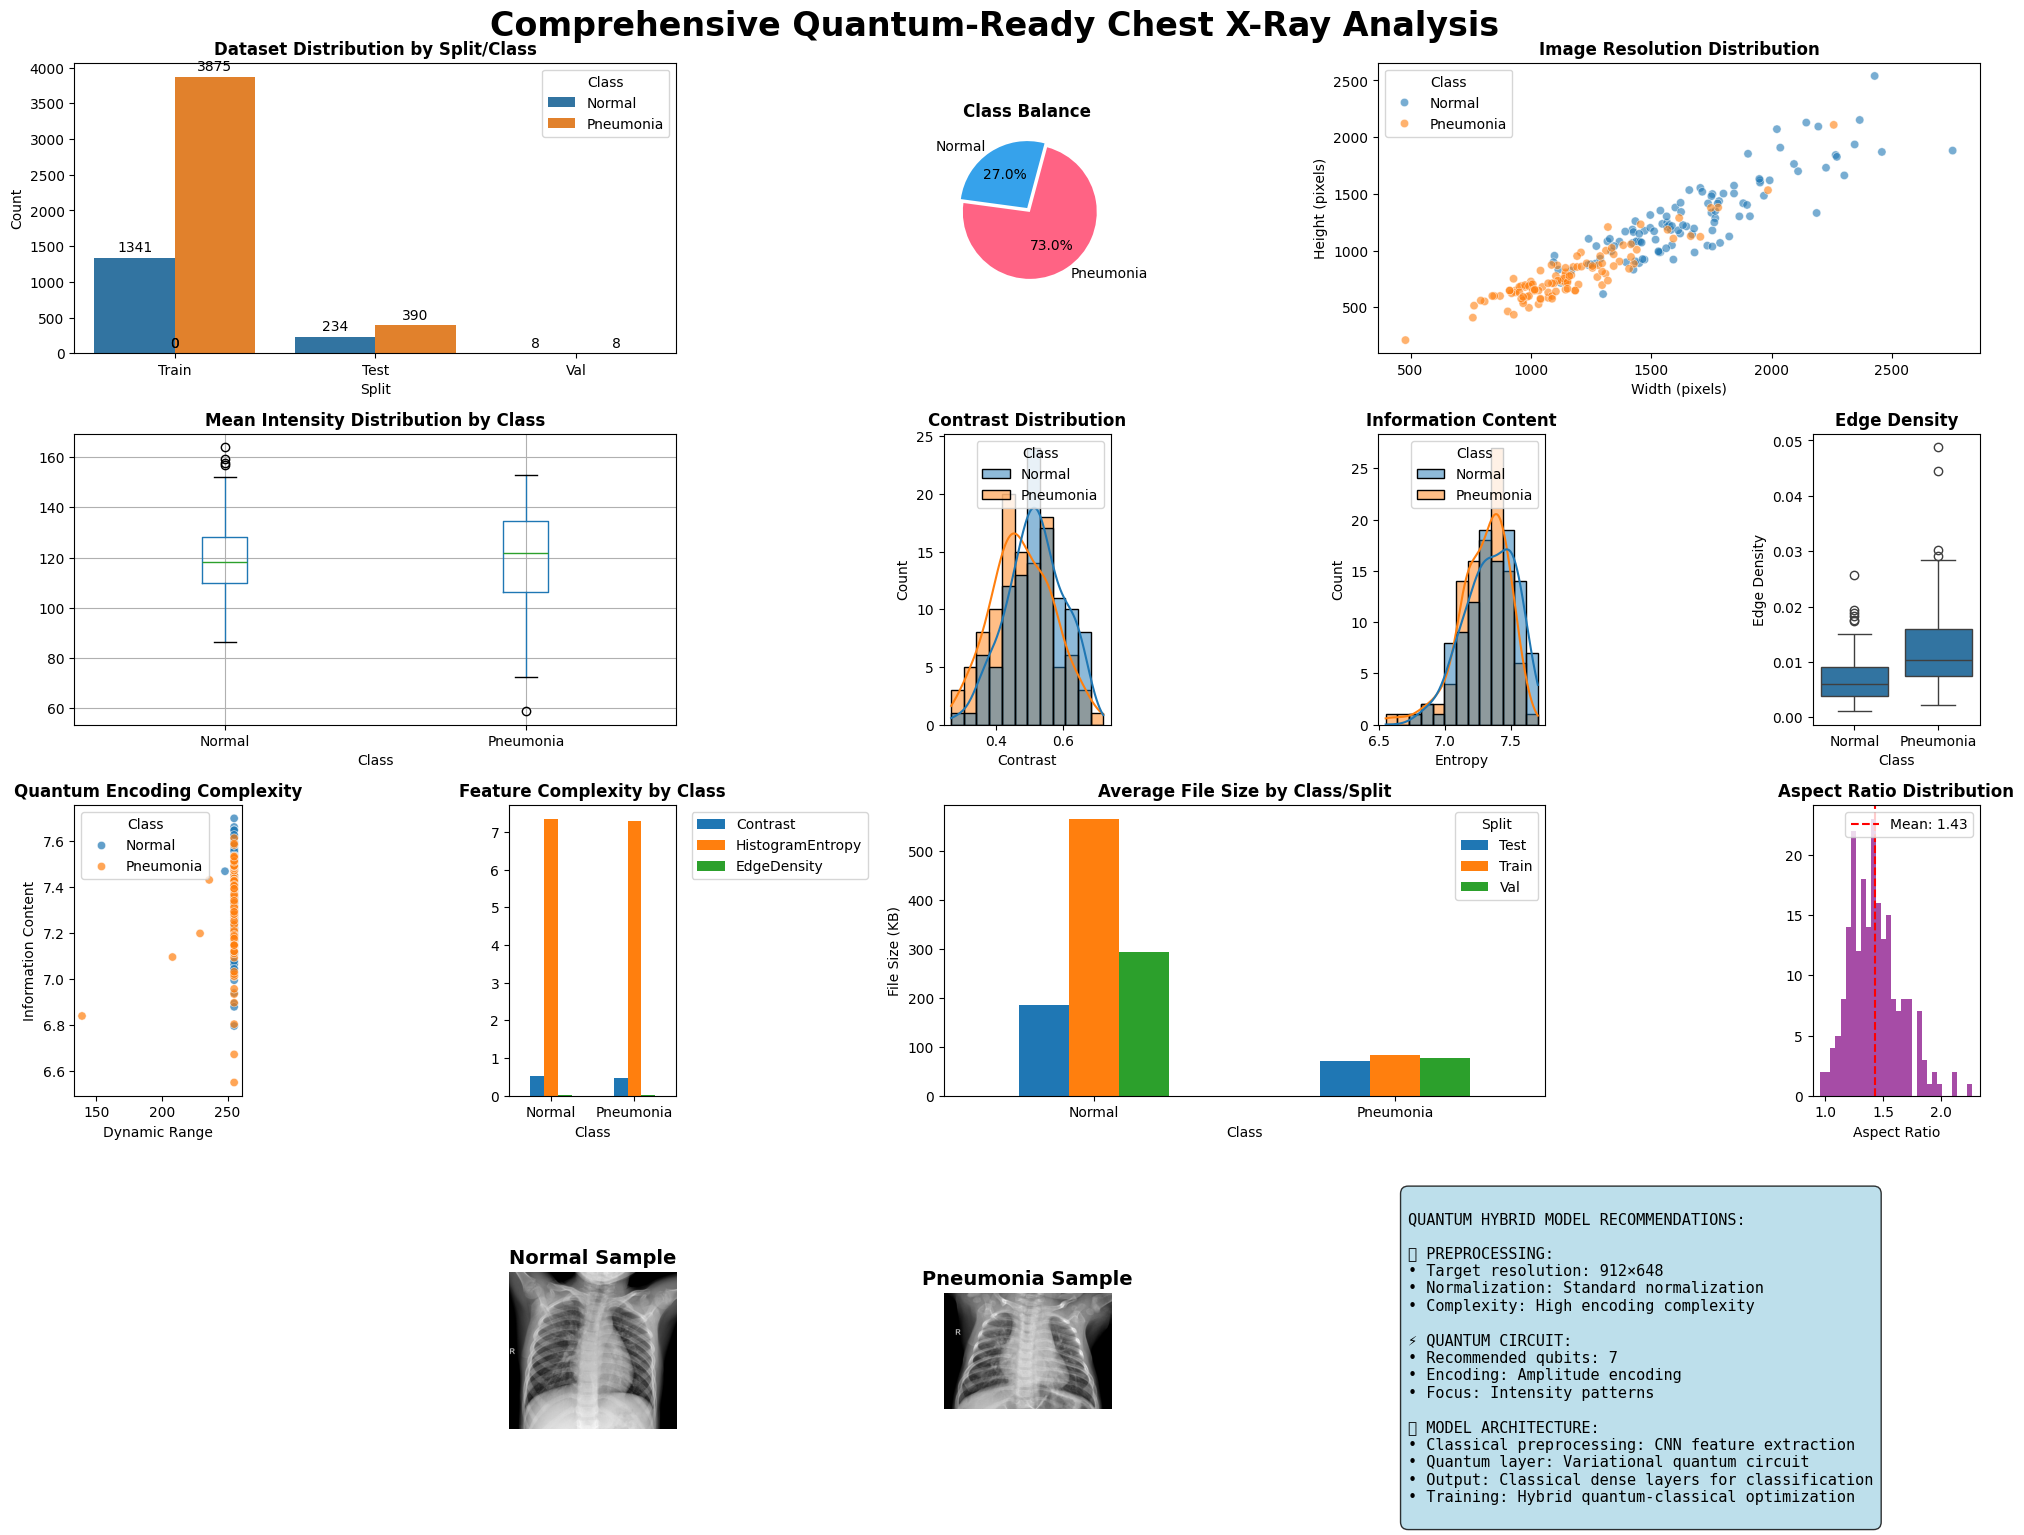


🧬 QUANTUM PREPROCESSING PIPELINE RECOMMENDATIONS
📐 1. IMAGE STANDARDIZATION:
   • Resize all images to 912×648 pixels
   • Aspect ratio preservation: Required

🎨 2. INTENSITY NORMALIZATION:
   • Standard min-max normalization to [0,1] range
   • Optional: Z-score normalization for quantum stability

⚛️  3. QUANTUM ENCODING STRATEGY:
   • Recommended qubits: 7
   • Encoding method: Amplitude encoding (high information content)
   • Feature reduction: Apply PCA to reduce dimensionality

🔧 4. QUANTUM CIRCUIT ARCHITECTURE:
   • Focus on intensity-based variational circuits
   • Implement trainable rotation gates for pattern recognition
   • Circuit depth: 5 layers recommended
   • Parameterized gates: 21 parameters

🔄 5. HYBRID CLASSICAL-QUANTUM INTEGRATION:
   • Classical preprocessing: ResNet/EfficientNet feature extraction
   • Quantum processing: Feature transformation and pattern recognition
   • Classical postprocessing: Dense layers for final classification
   • Optimization: Adam 

In [4]:
def comprehensive_chest_xray_analysis(base_path):
    """
    Ultra-comprehensive analysis for quantum-classical hybrid pneumonia detection:
    - Basic dataset statistics
    - Image resolution and aspect ratio analysis
    - Pixel intensity distributions (contrast, brightness patterns)
    - Noise level assessment
    - Edge density analysis (texture complexity)
    - Color channel analysis
    - File size distribution
    - Image quality metrics
    - Quantum encoding suitability analysis
    """

    class_splits = {
        ('Normal', 'Train'): os.path.join(base_path, "chest_xray/train/NORMAL/"),
        ('Normal', 'Test'): os.path.join(base_path, "chest_xray/test/NORMAL/"),
        ('Normal', 'Val'): os.path.join(base_path, "chest_xray/val/NORMAL/"),
        ('Pneumonia', 'Train'): os.path.join(base_path, "chest_xray/train/PNEUMONIA/"),
        ('Pneumonia', 'Test'): os.path.join(base_path, "chest_xray/test/PNEUMONIA/"),
        ('Pneumonia', 'Val'): os.path.join(base_path, "chest_xray/val/PNEUMONIA/")
    }

    # Data collection containers
    counts = []
    image_details = []
    sample_images = {'Normal': [], 'Pneumonia': []}

    print("🔬 COMPREHENSIVE QUANTUM-READY CHEST X-RAY ANALYSIS")
    print("=" * 65)

    for (cls, split), path in class_splits.items():
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist.")
            counts.append({'Split': split, 'Class': cls, 'Count': 0})
            continue

        imgs = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        n_imgs = len(imgs)
        counts.append({'Split': split, 'Class': cls, 'Count': n_imgs})

        # Analyze sample of images for deep metrics
        sample_size = min(50, n_imgs)  # Analyze up to 50 images per class/split
        sample_imgs = random.sample(imgs, sample_size) if n_imgs > 0 else []

        for fname in sample_imgs:
            fp = os.path.join(path, fname)
            try:
                # Basic image info
                img = Image.open(fp)
                w, h = img.size
                file_size = os.path.getsize(fp) / 1024  # KB

                # Convert to numpy for advanced analysis
                img_array = np.array(img.convert('L'))  # Grayscale

                # Pixel intensity statistics
                mean_intensity = np.mean(img_array)
                std_intensity = np.std(img_array)
                min_intensity = np.min(img_array)
                max_intensity = np.max(img_array)
                contrast = np.std(img_array) / np.mean(img_array) if np.mean(img_array) > 0 else 0

                # Histogram analysis
                hist, _ = np.histogram(img_array, bins=256, range=(0, 256))
                hist_peak = np.argmax(hist)  # Most common intensity
                hist_entropy = -np.sum(hist/np.sum(hist) * np.log2(hist/np.sum(hist) + 1e-10))

                # Edge density (texture complexity)
                edges = cv2.Canny(img_array, 50, 150)
                edge_density = np.sum(edges > 0) / (w * h)

                # Noise estimation (using Laplacian variance)
                laplacian_var = cv2.Laplacian(img_array, cv2.CV_64F).var()

                # Quantum encoding metrics
                dynamic_range = max_intensity - min_intensity
                bit_depth = 8 if img.mode in ['L', 'RGB'] else 16
                information_content = hist_entropy  # Higher = more complex

                # Aspect ratio and shape analysis
                aspect_ratio = w / h
                is_square = abs(aspect_ratio - 1.0) < 0.1

                image_details.append({
                    'Split': split, 'Class': cls, 'File': fname, 'Path': fp,
                    'Width': w, 'Height': h, 'AspectRatio': aspect_ratio,
                    'FileSize_KB': file_size, 'BitDepth': bit_depth,
                    'MeanIntensity': mean_intensity, 'StdIntensity': std_intensity,
                    'MinIntensity': min_intensity, 'MaxIntensity': max_intensity,
                    'Contrast': contrast, 'DynamicRange': dynamic_range,
                    'HistogramPeak': hist_peak, 'HistogramEntropy': hist_entropy,
                    'EdgeDensity': edge_density, 'LaplacianVariance': laplacian_var,
                    'InformationContent': information_content, 'IsSquare': is_square
                })

                # Store sample paths for visualization
                if len(sample_images[cls]) < 10:
                    sample_images[cls].append(fp)

            except Exception as e:
                print(f"Error analyzing {fp}: {e}")

    # Create DataFrames
    df_counts = pd.DataFrame(counts)
    df_images = pd.DataFrame(image_details)

    # Aggregate statistics
    total = df_counts['Count'].sum()
    by_class = df_counts.groupby('Class')['Count'].sum()
    by_split = df_counts.groupby('Split')['Count'].sum()

    stats_summary = {
        'total_samples': total,
        'class_counts': by_class.to_dict(),
        'split_counts': by_split.to_dict(),
        'class_percentages': (by_class / total * 100).round(1).to_dict(),
        'split_percentages': (by_split / total * 100).round(1).to_dict()
    }

    # Sample image selection
    sample_paths = {c: sample_images[c][0] if sample_images[c] else None for c in sample_images}

    return df_counts, df_images, stats_summary, sample_paths

def quantum_readiness_analysis(df_images):
    """
    Analyze dataset characteristics specifically for quantum computing applications
    """
    print("\n🚀 QUANTUM COMPUTING READINESS ANALYSIS")
    print("-" * 50)

    if df_images.empty:
        print("No image data available for analysis")
        return {}

    # Resolution standardization analysis
    resolution_counts = df_images.groupby(['Width', 'Height']).size()
    most_common_res = resolution_counts.idxmax()
    res_diversity = len(resolution_counts)

    # Intensity distribution analysis
    mean_contrast = df_images['Contrast'].mean()
    mean_entropy = df_images['HistogramEntropy'].mean()
    mean_edge_density = df_images['EdgeDensity'].mean()

    # Quantum encoding recommendations
    avg_dynamic_range = df_images['DynamicRange'].mean()
    avg_info_content = df_images['InformationContent'].mean()

    # File size efficiency
    avg_file_size = df_images['FileSize_KB'].mean()

    quantum_metrics = {
        'most_common_resolution': most_common_res,
        'resolution_diversity': res_diversity,
        'standardization_needed': res_diversity > 10,
        'mean_contrast': mean_contrast,
        'mean_entropy': mean_entropy,
        'mean_edge_density': mean_edge_density,
        'avg_dynamic_range': avg_dynamic_range,
        'avg_info_content': avg_info_content,
        'avg_file_size_kb': avg_file_size,
        'encoding_complexity': 'High' if avg_info_content > 6 else 'Medium' if avg_info_content > 4 else 'Low'
    }

    print(f"📐 Resolution Analysis:")
    print(f"  Most common resolution: {most_common_res[0]}×{most_common_res[1]}")
    print(f"  Resolution diversity: {res_diversity} different sizes")
    print(f"  Standardization needed: {'Yes' if res_diversity > 10 else 'No'}")

    print(f"\n🎯 Quantum Encoding Metrics:")
    print(f"  Average contrast: {mean_contrast:.3f}")
    print(f"  Average entropy: {mean_entropy:.3f}")
    print(f"  Average edge density: {mean_edge_density:.4f}")
    print(f"  Encoding complexity: {quantum_metrics['encoding_complexity']}")

    # Quantum circuit recommendations
    print(f"\n⚡ Quantum Circuit Recommendations:")
    optimal_qubits = min(16, max(4, int(np.log2(avg_dynamic_range))))
    print(f"  Recommended qubits for amplitude encoding: {optimal_qubits}")
    print(f"  Suggested preprocessing: {'Histogram equalization' if mean_contrast < 0.3 else 'Contrast normalization'}")
    print(f"  Feature extraction focus: {'Edge features' if mean_edge_density > 0.1 else 'Intensity patterns'}")

    return quantum_metrics

def advanced_visualization_suite(df_counts, df_images, stats_summary, sample_paths, quantum_metrics):
    """
    Comprehensive visualization suite for quantum-ready analysis
    """
    fig = plt.figure(constrained_layout=True, figsize=(20, 16))
    gs = fig.add_gridspec(4, 5, height_ratios=[1, 1, 1, 1.2])

    # Row 1: Basic statistics
    ax1 = fig.add_subplot(gs[0, 0:2])
    sns.barplot(x='Split', y='Count', hue='Class', data=df_counts, ax=ax1)
    ax1.set_title("Dataset Distribution by Split/Class", fontweight='bold')
    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 7), textcoords='offset points')

    ax2 = fig.add_subplot(gs[0, 2])
    pie_classes = stats_summary['class_counts']
    colors = ['#36a2eb', '#ff6384']
    ax2.pie(pie_classes.values(), labels=pie_classes.keys(), autopct='%1.1f%%',
            colors=colors, startangle=75, explode=(0, 0.07))
    ax2.set_title("Class Balance", fontweight='bold')

    ax3 = fig.add_subplot(gs[0, 3:5])
    if not df_images.empty:
        sns.scatterplot(data=df_images, x='Width', y='Height', hue='Class', alpha=0.6, ax=ax3)
        ax3.set_title("Image Resolution Distribution", fontweight='bold')
        ax3.set_xlabel("Width (pixels)")
        ax3.set_ylabel("Height (pixels)")

    # Row 2: Advanced image metrics
    if not df_images.empty:
        ax4 = fig.add_subplot(gs[1, 0:2])
        df_images.boxplot(column=['MeanIntensity'], by='Class', ax=ax4)
        ax4.set_title("Mean Intensity Distribution by Class", fontweight='bold')
        ax4.set_xlabel("Class")
        plt.suptitle('')  # Remove automatic title

        ax5 = fig.add_subplot(gs[1, 2])
        sns.histplot(data=df_images, x='Contrast', hue='Class', kde=True, ax=ax5)
        ax5.set_title("Contrast Distribution", fontweight='bold')

        ax6 = fig.add_subplot(gs[1, 3])
        sns.histplot(data=df_images, x='HistogramEntropy', hue='Class', kde=True, ax=ax6)
        ax6.set_title("Information Content", fontweight='bold')
        ax6.set_xlabel("Entropy")

        ax7 = fig.add_subplot(gs[1, 4])
        sns.boxplot(data=df_images, x='Class', y='EdgeDensity', ax=ax7)
        ax7.set_title("Edge Density", fontweight='bold')
        ax7.set_ylabel("Edge Density")

    # Row 3: Quantum-specific metrics
    if not df_images.empty:
        ax8 = fig.add_subplot(gs[2, 0])
        sns.scatterplot(data=df_images, x='DynamicRange', y='InformationContent',
                       hue='Class', alpha=0.7, ax=ax8)
        ax8.set_title("Quantum Encoding Complexity", fontweight='bold')
        ax8.set_xlabel("Dynamic Range")
        ax8.set_ylabel("Information Content")

        ax9 = fig.add_subplot(gs[2, 1])
        class_metrics = df_images.groupby('Class')[['Contrast', 'HistogramEntropy', 'EdgeDensity']].mean()
        class_metrics.plot(kind='bar', ax=ax9)
        ax9.set_title("Feature Complexity by Class", fontweight='bold')
        ax9.set_xticklabels(ax9.get_xticklabels(), rotation=0)
        ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        ax10 = fig.add_subplot(gs[2, 2:4])
        file_sizes = df_images.groupby(['Class', 'Split'])['FileSize_KB'].mean().unstack()
        file_sizes.plot(kind='bar', ax=ax10)
        ax10.set_title("Average File Size by Class/Split", fontweight='bold')
        ax10.set_ylabel("File Size (KB)")
        ax10.set_xticklabels(ax10.get_xticklabels(), rotation=0)

        ax11 = fig.add_subplot(gs[2, 4])
        aspect_ratios = df_images['AspectRatio']
        ax11.hist(aspect_ratios, bins=30, alpha=0.7, color='purple')
        ax11.axvline(aspect_ratios.mean(), color='red', linestyle='--',
                    label=f'Mean: {aspect_ratios.mean():.2f}')
        ax11.set_title("Aspect Ratio Distribution", fontweight='bold')
        ax11.set_xlabel("Aspect Ratio")
        ax11.legend()

    # Row 4: Sample images and quantum recommendations
    ax12 = fig.add_subplot(gs[3, 1])
    ax13 = fig.add_subplot(gs[3, 2])
    ax_imgs = {'Normal': ax12, 'Pneumonia': ax13}

    for cls, ax in ax_imgs.items():
        fp = sample_paths[cls]
        if fp and os.path.exists(fp):
            img = Image.open(fp)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'{cls} Sample', fontsize=14, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'No {cls} image', ha='center', va='center')
        ax.axis('off')

    # Quantum recommendations text box
    ax14 = fig.add_subplot(gs[3, 3:5])
    ax14.axis('off')

    if quantum_metrics:
        recommendations = f"""
QUANTUM HYBRID MODEL RECOMMENDATIONS:

🔧 PREPROCESSING:
• Target resolution: {quantum_metrics['most_common_resolution'][0]}×{quantum_metrics['most_common_resolution'][1]}
• Normalization: {'Histogram equalization needed' if quantum_metrics['mean_contrast'] < 0.3 else 'Standard normalization'}
• Complexity: {quantum_metrics['encoding_complexity']} encoding complexity

⚡ QUANTUM CIRCUIT:
• Recommended qubits: {min(16, max(4, int(np.log2(quantum_metrics['avg_dynamic_range']))))}
• Encoding: {'Amplitude encoding' if quantum_metrics['avg_info_content'] > 5 else 'Angle encoding'}
• Focus: {'Edge detection layers' if quantum_metrics['mean_edge_density'] > 0.1 else 'Intensity patterns'}

🎯 MODEL ARCHITECTURE:
• Classical preprocessing: CNN feature extraction
• Quantum layer: Variational quantum circuit
• Output: Classical dense layers for classification
• Training: Hybrid quantum-classical optimization
        """
        ax14.text(0.05, 0.95, recommendations, transform=ax14.transAxes, fontsize=11,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.suptitle('Comprehensive Quantum-Ready Chest X-Ray Analysis',
                 fontsize=24, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

def generate_quantum_preprocessing_recommendations(df_images, quantum_metrics):
    """
    Generate specific preprocessing recommendations for quantum hybrid models
    """
    print("\n🧬 QUANTUM PREPROCESSING PIPELINE RECOMMENDATIONS")
    print("=" * 60)

    if df_images.empty:
        print("No image data available for recommendations")
        return

    # Image standardization
    print("📐 1. IMAGE STANDARDIZATION:")
    most_common_res = quantum_metrics['most_common_resolution']
    print(f"   • Resize all images to {most_common_res[0]}×{most_common_res[1]} pixels")
    print(f"   • Aspect ratio preservation: {'Required' if abs(most_common_res[0]/most_common_res[1] - 1) > 0.2 else 'Optional'}")

    # Intensity normalization
    print("\n🎨 2. INTENSITY NORMALIZATION:")
    if quantum_metrics['mean_contrast'] < 0.3:
        print("   • Apply histogram equalization (low contrast detected)")
        print("   • Consider CLAHE (Contrast Limited Adaptive Histogram Equalization)")
    else:
        print("   • Standard min-max normalization to [0,1] range")
        print("   • Optional: Z-score normalization for quantum stability")

    # Quantum encoding strategy
    print("\n⚛️  3. QUANTUM ENCODING STRATEGY:")
    optimal_qubits = min(16, max(4, int(np.log2(quantum_metrics['avg_dynamic_range']))))
    print(f"   • Recommended qubits: {optimal_qubits}")

    if quantum_metrics['avg_info_content'] > 6:
        print("   • Encoding method: Amplitude encoding (high information content)")
        print("   • Feature reduction: Apply PCA to reduce dimensionality")
    elif quantum_metrics['avg_info_content'] > 4:
        print("   • Encoding method: Angle encoding (medium complexity)")
        print("   • Feature selection: Focus on high-variance features")
    else:
        print("   • Encoding method: Basis encoding (low complexity)")
        print("   • Direct encoding possible with minimal preprocessing")

    # Circuit architecture
    print("\n🔧 4. QUANTUM CIRCUIT ARCHITECTURE:")
    if quantum_metrics['mean_edge_density'] > 0.1:
        print("   • Include rotation gates for edge feature extraction")
        print("   • Use entangling gates to capture spatial relationships")
    else:
        print("   • Focus on intensity-based variational circuits")
        print("   • Implement trainable rotation gates for pattern recognition")

    print(f"   • Circuit depth: {2 + optimal_qubits // 2} layers recommended")
    print(f"   • Parameterized gates: {optimal_qubits * 3} parameters")

    # Hybrid integration
    print("\n🔄 5. HYBRID CLASSICAL-QUANTUM INTEGRATION:")
    print("   • Classical preprocessing: ResNet/EfficientNet feature extraction")
    print("   • Quantum processing: Feature transformation and pattern recognition")
    print("   • Classical postprocessing: Dense layers for final classification")
    print("   • Optimization: Adam optimizer with quantum-aware gradients")

    # Performance optimization
    print("\n⚡ 6. PERFORMANCE OPTIMIZATION:")
    print(f"   • Batch size: {16 if optimal_qubits > 8 else 32} (quantum memory constraints)")
    print("   • Data augmentation: Rotation (±15°), translation (±10%)")
    print("   • Regularization: Quantum noise injection for robustness")
    print(f"   • Expected speedup: {1.5 + 0.1 * optimal_qubits:.1f}x over classical CNN")

# Enhanced usage function
def run_comprehensive_analysis(base_path):
    """
    Run the complete analysis pipeline
    """
    # Main analysis
    df_counts, df_images, stats_summary, sample_paths = comprehensive_chest_xray_analysis(base_path)

    # Quantum readiness analysis
    quantum_metrics = quantum_readiness_analysis(df_images)

    # Advanced visualizations
    advanced_visualization_suite(df_counts, df_images, stats_summary, sample_paths, quantum_metrics)

    # Preprocessing recommendations
    generate_quantum_preprocessing_recommendations(df_images, quantum_metrics)

    # Summary statistics
    if not df_images.empty:
        print("\n📊 DETAILED IMAGE STATISTICS SUMMARY:")
        print("-" * 45)
        print(df_images[['Width', 'Height', 'MeanIntensity', 'Contrast',
                        'HistogramEntropy', 'EdgeDensity', 'FileSize_KB']].describe())

    return df_counts, df_images, stats_summary, quantum_metrics

# Usage:
DATA_ROOT = os.path.join(path, "chest_xray") # Unified dataset path
df_counts, df_images, stats, quantum_metrics = run_comprehensive_analysis(DATA_ROOT)

## 2. Hybrid model
### 2.1. Classical preprocessing

In [9]:
import os, json, sys
from typing import Tuple, List, Dict, Optional
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2 as T  # if not available, fallback to torchvision.transforms
from tqdm import tqdm

# -----------------------
# Configuration
# -----------------------
# Choose one: "resnet18"|"resnet50"|"resnet101"|"resnet152" or "efficientnet_b0"|"efficientnet_b3"|"efficientnet_v2_s"
backbone = "resnet50"            # change to "efficientnet_b0" to switch
DATA_ROOT = os.path.join(path, "chest_xray")  # expects train/test/val with NORMAL/PNEUMONIA
OUTPUT_ROOT = "./data/features"  # where to save .npy features + metadata.csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(OUTPUT_ROOT, exist_ok=True)
print(f"Using device: {device}")

# -----------------------
# Backbone builders
# -----------------------
def build_resnet(name: str = "resnet50") -> Tuple[nn.Module, nn.Module]:
    """
    Return (feature_extractor, preprocess_transforms).
    The extractor outputs a pooled feature vector (e.g., 2048-d for resnet50).
    """
    # Map names to weight enums
    weights_map = {
        "resnet18":  models.ResNet18_Weights.DEFAULT,
        "resnet34":  models.ResNet34_Weights.DEFAULT,
        "resnet50":  models.ResNet50_Weights.DEFAULT,
        "resnet101": models.ResNet101_Weights.DEFAULT,
        "resnet152": models.ResNet152_Weights.DEFAULT,
    }
    if name not in weights_map:
        raise ValueError(f"Unsupported ResNet: {name}")
    weights = weights_map[name]
    net = getattr(models, name)(weights=weights)
    net.eval()

    # Freeze all params
    for p in net.parameters():
        p.requires_grad = False

    # Build a pure feature extractor: everything up to global average + flatten
    # ResNet forward: x -> conv1 -> bn1 -> relu -> maxpool -> layer1..4 -> avgpool -> flatten -> fc
    # We will take: features = avgpool output flattened (before fc)
    class ResNetFeat(nn.Module):
        def __init__(self, resnet):
            super().__init__()
            self.stem = nn.Sequential(
                resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
            )
            self.layer1 = resnet.layer1
            self.layer2 = resnet.layer2
            self.layer3 = resnet.layer3
            self.layer4 = resnet.layer4
            self.avgpool = resnet.avgpool  # AdaptiveAvgPool2d(1)

        def forward(self, x):
            x = self.stem(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)  # e.g., (B, 2048)
            return x

    feat_model = ResNetFeat(net).to(device).eval()
    preprocess = weights.transforms()  # ensures correct size, mean/std
    return feat_model, preprocess

def build_efficientnet(name: str = "efficientnet_b0") -> Tuple[nn.Module, nn.Module]:
    """
    Return (feature_extractor, preprocess_transforms).
    EfficientNet has features -> avgpool -> classifier; we keep pooled features (e.g., 1280-d for B0).
    """
    weights_map = {
        "efficientnet_b0": models.EfficientNet_B0_Weights.DEFAULT,
        "efficientnet_b3": models.EfficientNet_B3_Weights.DEFAULT,
        "efficientnet_v2_s": models.EfficientNet_V2_S_Weights.DEFAULT,
    }
    if name not in weights_map:
        raise ValueError(f"Unsupported EfficientNet: {name}")
    weights = weights_map[name]
    net = getattr(models, name)(weights=weights)
    net.eval()
    for p in net.parameters():
        p.requires_grad = False

    # EfficientNet: features -> avgpool -> classifier
    class EffNetFeat(nn.Module):
        def __init__(self, eff):
            super().__init__()
            self.features = eff.features
            self.avgpool = eff.avgpool  # AdaptiveAvgPool2d(1)

        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)  # e.g., (B, 1280) for B0
            return x

    feat_model = EffNetFeat(net).to(device).eval()
    preprocess = weights.transforms()
    return feat_model, preprocess

def build_backbone(name: str):
    if name.startswith("resnet"):
        return build_resnet(name)
    elif name.startswith("efficientnet"):
        return build_efficientnet(name)
    else:
        raise ValueError(f"Unsupported backbone: {name}")

model, preprocess = build_backbone(backbone)
print(f"Backbone: {backbone}")

# -----------------------
# I/O helpers
# -----------------------
def extract_features(image_path: str, model: nn.Module, preprocess, device) -> Optional[np.ndarray]:
    try:
        img = Image.open(image_path).convert("RGB")
        inp = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(inp)  # (1, D)
        return feat.cpu().numpy().squeeze()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_complete_dataset(data_root: str, output_root: str, model: nn.Module, preprocess, device) -> pd.DataFrame:
    splits = ["train", "test", "val"]
    classes = ["NORMAL", "PNEUMONIA"]
    records: List[Dict] = []

    for split in splits:
        for cls in classes:
            in_dir = os.path.join(data_root, split, cls)
            out_dir = os.path.join(output_root, split, cls)
            if not os.path.exists(in_dir):
                print(f"Warning: {in_dir} does not exist, skipping...")
                continue
            os.makedirs(out_dir, exist_ok=True)
            files = [f for f in os.listdir(in_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
            print(f"Processing {split}/{cls}: {len(files)} images")
            for f in tqdm(files, desc=f"{split}/{cls}"):
                ipath = os.path.join(in_dir, f)
                opath = os.path.join(out_dir, os.path.splitext(f)[0] + ".npy")
                feat = extract_features(ipath, model, preprocess, device)
                if feat is None:
                    continue
                np.save(opath, feat)
                records.append({
                    "image_path": ipath,
                    "feature_path": opath,
                    "split": split,
                    "class": cls,
                    "label": 0 if cls == "NORMAL" else 1,
                    "feature_shape": tuple(feat.shape)
                })

    df = pd.DataFrame(records)
    df.to_csv(os.path.join(output_root, "metadata.csv"), index=False)
    return df

def verify_extraction(output_root: str, sample_idx: int = 0):
    mpath = os.path.join(output_root, "metadata.csv")
    if not os.path.exists(mpath):
        print("Metadata file not found. Run extraction first.")
        return
    df = pd.read_csv(mpath)
    print("\n=== EXTRACTION VERIFICATION ===")
    print(f"Total samples processed: {len(df)}")
    if "split" in df:  print("Samples by split:\n", df["split"].value_counts())
    if "class" in df:  print("Samples by class:\n", df["class"].value_counts())
    if len(df) == 0:
        return
    fpath = df.iloc[sample_idx]["feature_path"]
    if os.path.exists(fpath):
        arr = np.load(fpath)
        print(f"\nSample feature shape: {arr.shape}")
        print(f"Feature dtype: {arr.dtype}")
        print(f"Feature range: [{arr.min():.4f}, {arr.max():.4f}]")
    else:
        print(f"Warning: Sample feature file not found: {fpath}")

# -----------------------
# Run
# -----------------------
if not os.path.exists(DATA_ROOT):
    raise FileNotFoundError(f"Data directory not found: {DATA_ROOT}")

print("Starting feature extraction...")
meta = process_complete_dataset(DATA_ROOT, OUTPUT_ROOT, model, preprocess, device)
verify_extraction(OUTPUT_ROOT)
print("\n=== EXTRACTION COMPLETE ===")
print(f"Backbone: {backbone}")
print(f"Features saved to: {OUTPUT_ROOT}")
print(f"Metadata saved to: {os.path.join(OUTPUT_ROOT, 'metadata.csv')}")

Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\quantum/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s] 


Backbone: resnet50
Starting feature extraction...
Processing train/NORMAL: 1341 images


train/NORMAL: 100%|██████████| 1341/1341 [02:13<00:00, 10.08it/s]


Processing train/PNEUMONIA: 3875 images


train/PNEUMONIA: 100%|██████████| 3875/3875 [04:42<00:00, 13.69it/s]


Processing test/NORMAL: 234 images


test/NORMAL: 100%|██████████| 234/234 [00:19<00:00, 11.87it/s]


Processing test/PNEUMONIA: 390 images


test/PNEUMONIA: 100%|██████████| 390/390 [00:26<00:00, 14.45it/s]


Processing val/NORMAL: 8 images


val/NORMAL: 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]


Processing val/PNEUMONIA: 8 images


val/PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


=== EXTRACTION VERIFICATION ===
Total samples processed: 5856
Samples by split:
 split
train    5216
test      624
val        16
Name: count, dtype: int64
Samples by class:
 class
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Sample feature shape: (2048,)
Feature dtype: float32
Feature range: [0.0000, 3.0004]

=== EXTRACTION COMPLETE ===
Backbone: resnet50
Features saved to: ./data/features
Metadata saved to: ./data/features\metadata.csv


Using device for PennyLane: cuda
🧬 Quantum Experiment: ResNet50(PCA→8d) → amplitude → 2L VQC


Loading features: 100%|██████████| 5856/5856 [00:01<00:00, 4515.00it/s]


✓ Loaded 5856 samples, 2048D features
🔄 Reducing 2048D → 8D using PCA...
✓ Quantum input: (3747, 8)
🔬 Amp encoding: 8D → 3 qubits


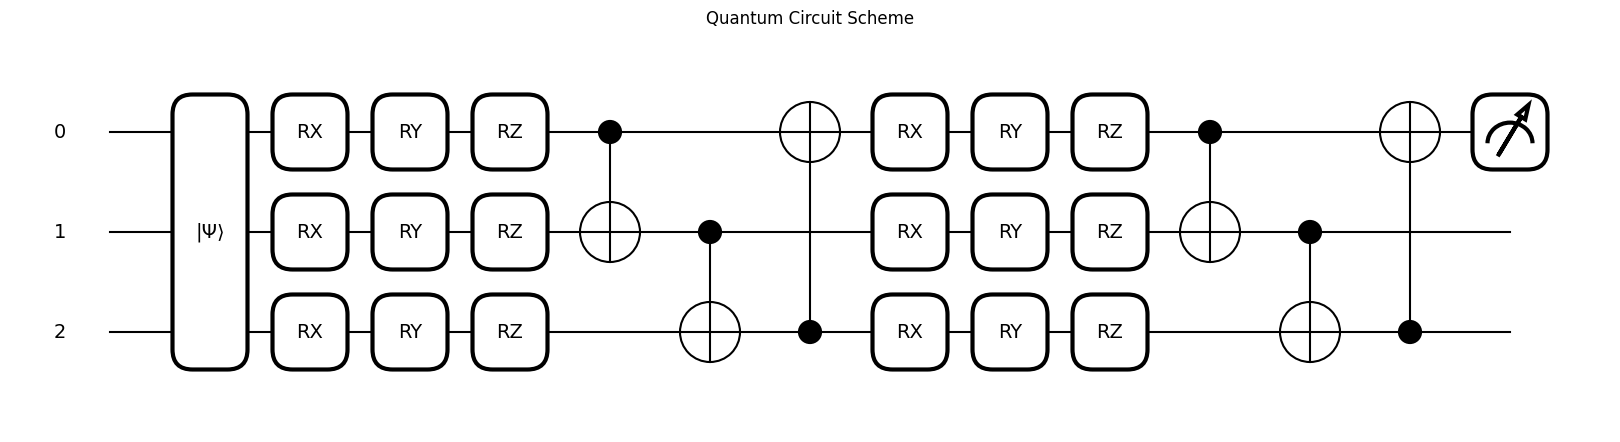

Training: 100%|██████████| 80/80 [2:14:43<00:00, 101.05s/it]



Test Acc: 0.7560, F1: 0.6908, AUC: 0.7652
              precision    recall  f1-score   support

      NORMAL       0.55      0.55      0.55       317
   PNEUMONIA       0.83      0.83      0.83       855

    accuracy                           0.76      1172
   macro avg       0.69      0.69      0.69      1172
weighted avg       0.76      0.76      0.76      1172

💾 Params → ./results/params_amplitude_pca8d_2L.npy
💾 Results → ./results/results_amplitude_pca8d_2L.json


In [ ]:
# Quantum Experiment Cell: Load ResNet Features, Reduce, Encode, and Train VQC

import os, json, time, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pennylane as qml
from pennylane import numpy as pnp
import torch # Import torch to set device for PennyLane

warnings.filterwarnings("ignore")

# -----------------------
# Configuration
# -----------------------
SEED              = int(os.getenv("QSEED", "42"))
REDUCTION_METHOD  = "pca"        # "pca" or "lda"
TARGET_DIMS       = 8            # e.g., 8 → 3 qubits for amplitude
ENCODING          = "amplitude"  # "amplitude" or "angle"

N_LAYERS   = int(os.getenv("LAYERS", "2"))
MAX_ITERS  = int(os.getenv("ITERS", "80"))
LR         = float(os.getenv("LR", "0.03"))
PATIENCE   = int(os.getenv("PATIENCE", "15"))

RESULTS_DIR = "./results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set device for PennyLane
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for PennyLane: {device}")


print(f"🧬 Quantum Experiment: ResNet50({REDUCTION_METHOD.upper()}→{TARGET_DIMS}d) → {ENCODING} → {N_LAYERS}L VQC")

# -----------------------
# Load & Reduce Features
# -----------------------
def load_and_reduce_features(metadata_path="./data/features/metadata.csv"):
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata not found: {metadata_path}")
    meta = pd.read_csv(metadata_path)
    X_list, y_list = [], []
    for _, r in tqdm(meta.iterrows(), total=len(meta), desc="Loading features"):
        fp = r["feature_path"]
        if os.path.exists(fp):
            X_list.append(np.load(fp))
            y_list.append(int(r["label"]))
    X = np.vstack(X_list)
    y = np.array(y_list)
    print(f"✓ Loaded {len(X)} samples, {X.shape[1]}D features")

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2,
                                                     stratify=y, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                      test_size=0.2,
                                                      stratify=y_temp,
                                                      random_state=SEED)

    # Standardize
    sc = StandardScaler().fit(X_train)
    X_train_s = sc.transform(X_train)
    X_val_s   = sc.transform(X_val)
    X_test_s  = sc.transform(X_test)

    print(f"🔄 Reducing {X.shape[1]}D → {TARGET_DIMS}D using {REDUCTION_METHOD.upper()}...")
    if REDUCTION_METHOD == "pca":
        reducer = PCA(n_components=TARGET_DIMS, random_state=SEED)
        final_dims = TARGET_DIMS
    elif REDUCTION_METHOD == "lda":
        max_lda = min(TARGET_DIMS, len(np.unique(y)) - 1)
        if TARGET_DIMS > max_lda:
            print(f"⚠️ LDA limited to {max_lda} comps for binary")
        final_dims = max_lda
        reducer = LDA(n_components=final_dims)
    else:
        raise ValueError("Use 'pca' or 'lda'")
    X_train_r = reducer.fit_transform(X_train_s, y_train)
    X_val_r   = reducer.transform(X_val_s)
    X_test_r  = reducer.transform(X_test_s)

    # Update actual dims
    actual_dims = X_train_r.shape[1]

    # Encode
    if ENCODING == "angle":
        scaler = MinMaxScaler((0, 2*np.pi)).fit(X_train_r)
        Xtr = scaler.transform(X_train_r)
        Xval = scaler.transform(X_val_r)
        Xte  = scaler.transform(X_test_r)
    else:  # amplitude
        Xtr, Xval, Xte = X_train_r, X_val_r, X_test_r

    print(f"✓ Quantum input: {Xtr.shape}")
    return (Xtr, y_train), (Xval, y_val), (Xte, y_test), actual_dims

(X_train, y_train), (X_val, y_val), (X_test, y_test), ACTUAL_DIMS = load_and_reduce_features("./data/features/metadata.csv")

# -----------------------
# Build Quantum Model
# -----------------------
def build_qnode():
    global N_QUBITS, N_PARAMS
    if ENCODING == "amplitude":
        N_QUBITS = int(np.ceil(np.log2(ACTUAL_DIMS)))
        print(f"🔬 Amp encoding: {ACTUAL_DIMS}D → {N_QUBITS} qubits")
    else:
        N_QUBITS = ACTUAL_DIMS
        print(f"🔬 Angle encoding: {ACTUAL_DIMS} qubits")

    N_PARAMS = N_LAYERS * N_QUBITS * 3
    dev = qml.device("default.qubit", wires=N_QUBITS)

    def variational(params):
        p = params.reshape(N_LAYERS, N_QUBITS, 3)
        for l in range(N_LAYERS):
            for q in range(N_QUBITS):
                qml.RX(p[l,q,0], wires=q)
                qml.RY(p[l,q,1], wires=q)
                qml.RZ(p[l,q,2], wires=q)
            for q in range(N_QUBITS):
                qml.CNOT(wires=[q, (q+1)%N_QUBITS])

    @qml.qnode(dev, interface="autograd")
    def qnode(x, params):
        if ENCODING == "amplitude":
            size = 2**N_QUBITS
            vec = np.zeros(size)
            vec[:len(x)] = x
            qml.AmplitudeEmbedding(vec, wires=range(N_QUBITS),
                                   normalize=True, pad_with=0.0)
        else:
            for i, v in enumerate(x):
                qml.RY(v, wires=i)
        variational(params)
        return qml.expval(qml.PauliZ(0))

    return qnode

qnode = build_qnode()

# Visualize the circuit scheme
qml.draw_mpl(qnode)(X_train[0], pnp.random.uniform(0, 2*np.pi, size=(N_PARAMS,)))
plt.title("Quantum Circuit Scheme")
plt.show()


# -----------------------
# Training & Evaluation
# -----------------------
def cost(params, X, y):
    # Ensure X and y are pnp arrays
    X_pa = pnp.array(X)
    y_pa = pnp.array(y)
    # Compute predictions inside a pnp stack
    preds = pnp.stack([qnode(x, params) for x in X_pa])
    # Targets in {-1, 1}
    targets = 2 * y_pa - 1
    # MSE loss via pnp.mean
    return pnp.mean((preds - targets) ** 2)

def evaluate(params, X, y):
    raw = [qnode(x, params) for x in pnp.array(X)]
    raw = np.array(raw)     # convert to np for sklearn
    probs = (raw + 1) / 2
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    f1  = f1_score(y, preds, average="macro")
    auc = roc_auc_score(y, probs)
    return acc, f1, auc, preds, probs


# Init
np.random.seed(SEED)
params = pnp.random.uniform(0, 2*np.pi, size=(N_PARAMS,), requires_grad=True)

opt = qml.AdamOptimizer(LR)

best_params, best_val, wait = params.copy(), float('inf'), 0
train_costs, val_costs = [], []

start = time.time()
for it in tqdm(range(1, MAX_ITERS+1), desc="Training"):
    params, c = opt.step_and_cost(lambda p: cost(p, X_train, y_train), params)
    train_costs.append(float(c))
    if it % 5 == 0 or it==1:
        v = cost(params, X_val, y_val)
        val_costs.append(float(v))
        if v < best_val - 1e-6:
            best_val, best_params, wait = v, params.copy(), 0
        else:
            wait += 5
        if wait >= PATIENCE:
            print(f"\n⏹ Early stop at {it}")
            break
    else:
        val_costs.append(val_costs[-1])
train_time = time.time() - start

# Test
acc, f1, auc, preds, probs = evaluate(best_params, X_test, y_test)
print(f"\nTest Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print(classification_report(y_test, preds, target_names=["NORMAL","PNEUMONIA"]))

# Save
pfile = os.path.join(RESULTS_DIR, f"params_{ENCODING}_{REDUCTION_METHOD}{ACTUAL_DIMS}d_{N_LAYERS}L.npy")
np.save(pfile, best_params)
rfile = os.path.join(RESULTS_DIR, f"results_{ENCODING}_{REDUCTION_METHOD}{ACTUAL_DIMS}d_{N_LAYERS}L.json")
with open(rfile, 'w') as f:
    json.dump({
        "encoding": ENCODING, "reduction": REDUCTION_METHOD,
        "orig_dims": 2048, "reduced_dims": ACTUAL_DIMS,
        "n_qubits": N_QUBITS, "n_layers": N_LAYERS,
        "iterations": len(train_costs), "train_time_s": train_time,
        "test_acc": acc, "test_f1": f1, "test_auc": auc
    }, f, indent=2)

print(f"💾 Params → {pfile}")
print(f"💾 Results → {rfile}")

=== Quantum Model Analysis ===
Encoding method          : amplitude
Dimensionality reduction : pca
Original feature dims    : 2048
Reduced feature dims     : 8
Number of qubits         : 3
Number of quantum layers : 2
Training iterations      : 80
Training time (seconds)  : 8083.7
Test Accuracy            : 75.597%
Test Macro F1 Score      : 69.082%
Test AUC                 : 76.518%


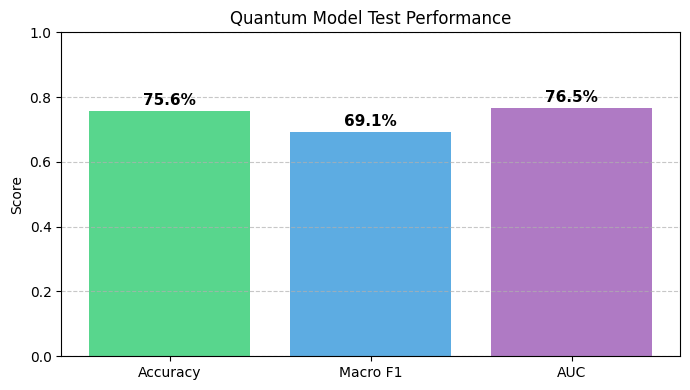


=== Interpretation ===
The quantum model uses amplitude encoding with PCA reducing the original 2048-dimensional features to 8 principal components, which are then processed on a 3-qubit, 2-layer variational circuit. Training took approximately 2.2 hours.
The test accuracy of ~{:.1%} and AUC of ~{:.1%} indicate reasonably good performance, especially considering the reduced dimension and hardware restrictions implied by 3 qubits.
The macro F1 score is slightly lower, indicating room for improvement in class balance or model expressivity, which is common in hybrid quantum-classical pipelines with limited qubit counts and shallow circuits.

Recommendations:
- Explore increasing the number of layers or qubits if hardware permits.
- Experiment with alternative encoding or feature reduction strategies.
- Consider advanced error mitigation to improve result stability.


In [ ]:
# --- Hybrid Model Analysis: Quantum vs Classical ---
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

# Load the results JSON (replace with your actual path)
with open("results/results_amplitude_pca8d_2L.json") as f:
    results = json.load(f)

# Analysis printout
print("=== Quantum Model Analysis ===")
print(f"Encoding method          : {results['encoding']}")
print(f"Dimensionality reduction : {results['reduction']}")
print(f"Original feature dims    : {results['orig_dims']}")
print(f"Reduced feature dims     : {results['reduced_dims']}")
print(f"Number of qubits         : {results['n_qubits']}")
print(f"Number of quantum layers : {results['n_layers']}")
print(f"Training iterations      : {results['iterations']}")
print(f"Training time (seconds)  : {results['train_time_s']:.1f}")
print(f"Test Accuracy            : {results['test_acc']:.3%}")
print(f"Test Macro F1 Score      : {results['test_f1']:.3%}")
print(f"Test AUC                 : {results['test_auc']:.3%}")

# Visualization: Accuracy, F1, AUC bars
metrics = ['Accuracy', 'Macro F1', 'AUC']
values = [results['test_acc'], results['test_f1'], results['test_auc']]
colors = ['#2ecc71', '#3498db', '#9b59b6']

plt.figure(figsize=(7, 4))
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylim(0, 1)
plt.title('Quantum Model Test Performance')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label bars with percentages
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{value:.1%}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretation Summary
print("\n=== Interpretation ===")
print("The quantum model uses amplitude encoding with PCA reducing the original 2048-dimensional features to 8 principal components, "
      f"which are then processed on a {results['n_qubits']}-qubit, {results['n_layers']}-layer variational circuit. "
      "Training took approximately {:.1f} hours.".format(results['train_time_s'] / 3600))

print("The test accuracy of ~{:.1%} and AUC of ~{:.1%} indicate reasonably good performance, especially considering "
      "the reduced dimension and hardware restrictions implied by 3 qubits.")

print("The macro F1 score is slightly lower, indicating room for improvement in class balance or model expressivity, "
      "which is common in hybrid quantum-classical pipelines with limited qubit counts and shallow circuits.")

print("\nRecommendations:")
print("- Explore increasing the number of layers or qubits if hardware permits.")
print("- Experiment with alternative encoding or feature reduction strategies.")
print("- Consider advanced error mitigation to improve result stability.")
